In [1]:
import chromadb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import autorootcwd

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style('whitegrid')

## 1. ChromaDB 연결 및 기본 정보

In [2]:
# ChromaDB 클라이언트 초기화
client = chromadb.PersistentClient(path="chromadb")

# 사용 가능한 컬렉션 목록
collections = client.list_collections()
print(f"총 {len(collections)}개의 컬렉션이 있습니다:\n")
collections = sorted(collections, key=lambda col: col.name)
for col in collections:
    print(f"  - {col.name}: {col.count()} documents")

총 12개의 컬렉션이 있습니다:

  - iclr_2021: 12616 documents
  - iclr_2022: 12819 documents
  - iclr_2023: 18127 documents
  - iclr_2024: 11002 documents
  - iclr_2025: 18639 documents
  - icml_2025: 15735 documents
  - neurips_2021: 13504 documents
  - neurips_2022: 15965 documents
  - neurips_2023: 17572 documents
  - neurips_2024: 19890 documents
  - neurips_2025: 26637 documents
  - tmlr: 21000 documents


In [14]:
# 컬렉션 선택
collection_name = "tmlr"  # 필요시 변경
collection = client.get_collection(name=collection_name)

print(f"컬렉션: {collection_name}")
print(f"총 문서 수: {collection.count()}")
print(f"메타데이터: {collection.metadata}")

컬렉션: tmlr
총 문서 수: 21000
메타데이터: {'description': 'tmlr paper abstracts and reviews'}


## 2. 데이터 샘플 확인

In [15]:
# 처음 10개 문서 가져오기
results = collection.get(
    limit=10,
    include=['documents', 'metadatas']
)

# DataFrame으로 변환하여 보기 쉽게 표시
df_sample = pd.DataFrame({
    'id': results['ids'],
    'type': [m['type'] for m in results['metadatas']],
    'forum_id': [m['forum_id'] for m in results['metadatas']],
    'content_preview': [doc[:100] + '...' for doc in results['documents']]
})

print("\n샘플 데이터:")
df_sample


샘플 데이터:


,id,type,forum_id,content_preview
0,abs_0WP1w7GKTg,abstract,0WP1w7GKTg,Abstract: Distribution shift severely degrades...
1,rev_pUwMJe7xnH,review,0WP1w7GKTg,Review: ## Summary Of Contributions\nThis pape...
2,rev_jGdifUZcKL,review,0WP1w7GKTg,Review: ## Summary Of Contributions\nThis pape...
3,rev_sCXmJG3awg,review,0WP1w7GKTg,Review: ## Summary Of Contributions\nThe paper...
4,abs_5Wb5c0FaCG,abstract,5Wb5c0FaCG,Abstract: Multimodal Large Language Models (ML...
5,rev_tAY8jmS6JN,review,5Wb5c0FaCG,Review: ## Summary Of Contributions\nThis pape...
6,rev_3jLw40cIBq,review,5Wb5c0FaCG,Review: ## Summary Of Contributions\nThis pape...
7,rev_nDn9affn4w,review,5Wb5c0FaCG,Review: ## Summary Of Contributions\nThe paper...
8,abs_WscAU9It1l,abstract,WscAU9It1l,Abstract: Detecting AI-generated text is an in...
9,rev_UOh7ygoltg,review,WscAU9It1l,Review: ## Summary Of Contributions\nThe submi...


## 3. 전체 데이터 통계

In [16]:
# 전체 데이터 가져오기 (메타데이터만)
all_data = collection.get(
    include=['metadatas', 'documents']
)

# 문서 타입별 분포
types = [m['type'] for m in all_data['metadatas']]
type_counts = Counter(types)

print("\n문서 타입별 분포:")
for type_name, count in type_counts.items():
    print(f"  {type_name}: {count}")

# 논문 수 계산 (abstract 개수)
num_papers = type_counts.get('abstract', 0)
num_reviews = type_counts.get('review', 0)
avg_reviews_per_paper = num_reviews / num_papers if num_papers > 0 else 0

print(f"\n총 논문 수: {num_papers}")
print(f"총 리뷰 수: {num_reviews}")
print(f"논문당 평균 리뷰 수: {avg_reviews_per_paper:.2f}")


문서 타입별 분포:
  abstract: 5113
  review: 15887

총 논문 수: 5113
총 리뷰 수: 15887
논문당 평균 리뷰 수: 3.11


## 4. 데이터 시각화

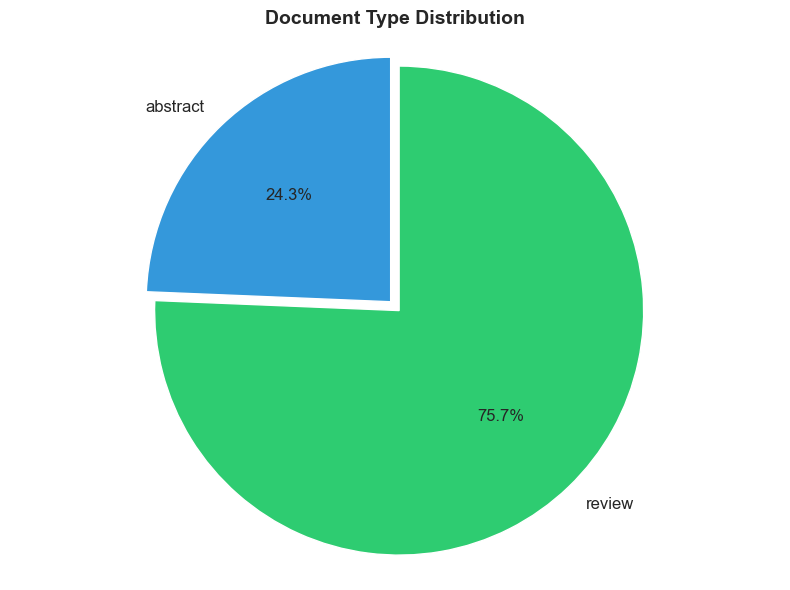

In [17]:
# 문서 타입 분포 - 파이 차트만 표시
fig, ax = plt.subplots(figsize=(8, 6))
labels = list(type_counts.keys())
sizes = list(type_counts.values())
colors = ['#3498db', '#2ecc71'][:len(labels)]
explode = [0.05 if s == max(sizes) else 0 for s in sizes]

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
       colors=colors, explode=explode, textprops={'fontsize': 12})
ax.set_title('Document Type Distribution', fontsize=14, fontweight='bold')
ax.axis('equal')  # 원형 유지

plt.tight_layout()
plt.show()

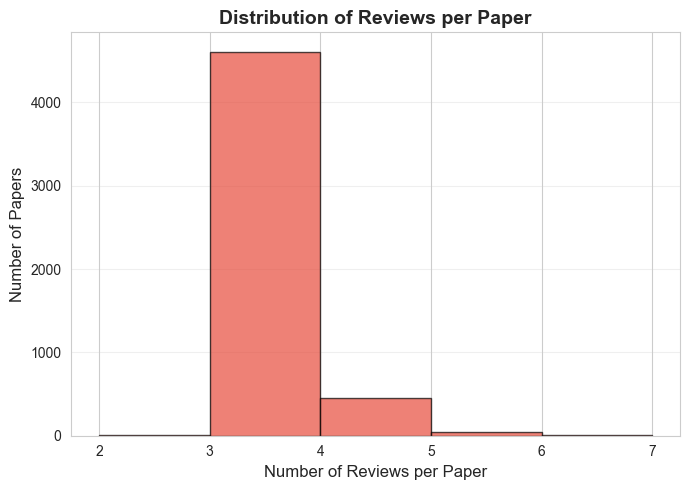


리뷰 수 통계:
  최소: 2
  최대: 6
  평균: 3.11
  중앙값: 3.0
  표준편차: 0.35


In [18]:
# 논문별 리뷰 수 분포
forum_ids = [m['forum_id'] for m in all_data['metadatas'] if m['type'] == 'review']
reviews_per_paper = Counter(forum_ids)
review_counts = list(reviews_per_paper.values())

fig, ax = plt.subplots(figsize=(7, 5))

# 히스토그램
ax.hist(review_counts, bins=range(min(review_counts), max(review_counts)+2),
        edgecolor='black', alpha=0.7, color='#e74c3c')
ax.set_xlabel('Number of Reviews per Paper', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.set_title('Distribution of Reviews per Paper', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n리뷰 수 통계:")
print(f"  최소: {min(review_counts)}")
print(f"  최대: {max(review_counts)}")
print(f"  평균: {np.mean(review_counts):.2f}")
print(f"  중앙값: {np.median(review_counts):.1f}")
print(f"  표준편차: {np.std(review_counts):.2f}")

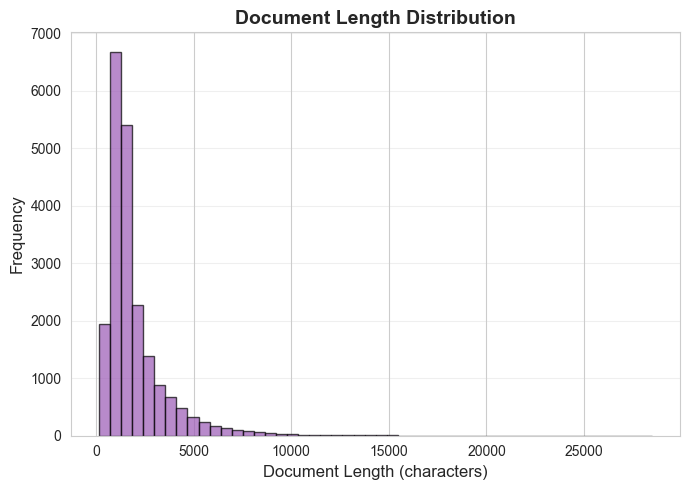


문서 길이 통계:
  Abstract 평균: 1318 characters
  Review 평균: 2148 characters


In [19]:
# 문서 길이 분포
doc_lengths = [len(doc) for doc in all_data['documents']]
abstract_lengths = [len(doc) for doc, meta in zip(all_data['documents'], all_data['metadatas'])
                    if meta['type'] == 'abstract']
review_lengths = [len(doc) for doc, meta in zip(all_data['documents'], all_data['metadatas'])
                  if meta['type'] == 'review']

fig, axes = plt.subplots(1, 1, figsize=(7, 5))

# 전체 문서 길이 히스토그램
axes.hist(doc_lengths, bins=50, edgecolor='black', alpha=0.7, color='#9b59b6')
axes.set_xlabel('Document Length (characters)', fontsize=12)
axes.set_ylabel('Frequency', fontsize=12)
axes.set_title('Document Length Distribution', fontsize=14, fontweight='bold')
axes.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n문서 길이 통계:")
print(f"  Abstract 평균: {np.mean(abstract_lengths):.0f} characters")
print(f"  Review 평균: {np.mean(review_lengths):.0f} characters")

## 5. 유사도 검색 테스트

In [20]:
# 샘플 쿼리로 검색
query = "What are the main weaknesses of this paper?"

results = collection.query(
    query_texts=[query],
    n_results=5
)

print(f"Query: {query}\n")
print("="*80)

for i, (doc, meta, distance) in enumerate(zip(
    results['documents'][0],
    results['metadatas'][0],
    results['distances'][0]
)):
    print(f"\n[Result {i+1}] (Distance: {distance:.4f})")
    print(f"Type: {meta['type']}")
    print(f"Forum ID: {meta['forum_id']}")
    print(f"Content: {doc[:300]}...")
    print("-"*80)

Query: What are the main weaknesses of this paper?


[Result 1] (Distance: 0.8940)
Type: review
Forum ID: Gz5HMiJLqv
Content: Review: ## Summary Of Contributions
The paper core contribution is introducing the split-brain syndrome in LLM/LRMs: the fact that they know an algorithm but they cannot execute it reliably. Specifically, the authors argue that there are architectural limitations on current models that prevent them ...
--------------------------------------------------------------------------------

[Result 2] (Distance: 0.9191)
Type: review
Forum ID: Gp0pHyUyrb
Content: Review: ## Summary Of Contributions
This paper studies unconstrained min-max problems which have at least one weak-Minty solution. For such problems the authors study an extension of the optimistic gradient descent-ascent algorithm and show that it converges in a slightly larger parameters regime th...
--------------------------------------------------------------------------------

[Result 3] (Distance: 0.9243)

In [21]:
# 다양한 쿼리 테스트
queries = [
    "experimental validation and empirical results",
    "theoretical contribution and novelty",
    "reproducibility and code availability",
    "limitations and future work"
]

for query in queries:
    results = collection.query(
        query_texts=[query],
        n_results=3
    )

    print(f"\nQuery: '{query}'")
    print(f"Top result distance: {results['distances'][0][0]:.4f}")
    print(f"Type: {results['metadatas'][0][0]['type']}")
    print(f"Preview: {results['documents'][0][0][:150]}...")
    print("-"*80)


Query: 'experimental validation and empirical results'
Top result distance: 0.9014
Type: review
Preview: Review: ## Summary Of Contributions
The paper investigates the problem of how to ensure that experimental evaluation is sufficient to ensure the metho...
--------------------------------------------------------------------------------

Query: 'theoretical contribution and novelty'
Top result distance: 0.9787
Type: review
Preview: Review: ## Summary Of Contributions
The paper proposes a unifying view of several related areas of generally independent research: Outlier Detection, ...
--------------------------------------------------------------------------------

Query: 'reproducibility and code availability'
Top result distance: 1.0031
Type: review
Preview: Review: ## Summary Of Contributions
The paper develops an automated pipeline to assess the adoption of best practices in software engineering in paper...
---------------------------------------------------------------------------

## 6. 특정 논문의 모든 리뷰 조회

In [22]:
# 첫 번째 논문의 forum_id 가져오기
first_abstract = [m for m in all_data['metadatas'] if m['type'] == 'abstract'][0]
forum_id = first_abstract['forum_id']

print(f"Forum ID: {forum_id}\n")

# 해당 논문의 abstract와 모든 리뷰 가져오기
paper_data = collection.get(
    where={"forum_id": forum_id},
    include=['documents', 'metadatas']
)

# Abstract 출력
for doc, meta in zip(paper_data['documents'], paper_data['metadatas']):
    if meta['type'] == 'abstract':
        print("[ABSTRACT]")
        print(doc)
        print("\n" + "="*80 + "\n")

# 리뷰들 출력
review_count = 0
for doc, meta in zip(paper_data['documents'], paper_data['metadatas']):
    if meta['type'] == 'review':
        review_count += 1
        print(f"[REVIEW {review_count}]")
        print(f"Note ID: {meta.get('note_id', 'N/A')}")
        print(doc)
        print("\n" + "-"*80 + "\n")

print(f"\n총 {review_count}개의 리뷰")

Forum ID: 0WP1w7GKTg

[ABSTRACT]
Abstract: Distribution shift severely degrades the performance of deep forecasting models. While this issue is well-studied for individual time series, it remains a significant challenge in the spatio-temporal domain. Effective solutions like instance normalization and its variants can mitigate temporal shifts by standardizing statistics. However, distribution shift on a graph is far more complex, involving not only the drift of individual node series but also heterogeneity across the spatial network where different nodes exhibit distinct statistical properties. To tackle this problem, we propose Reversible Residual Normalization (RRN), a novel framework that performs spatially-aware invertible transformations to address distribution shift in both spatial and temporal dimensions. Our approach integrates graph convolutional operations within invertible residual blocks, enabling adaptive normalization that respects the underlying graph structure while mai

## 7. 커스텀 검색 (필터링)

In [23]:
# 리뷰만 검색
query = "model architecture and design choices"

results = collection.query(
    query_texts=[query],
    n_results=3,
    where={"type": "review"}  # 리뷰만 필터링
)

print(f"Query: {query} (Reviews only)\n")
print("="*80)

for i, (doc, meta, distance) in enumerate(zip(
    results['documents'][0],
    results['metadatas'][0],
    results['distances'][0]
)):
    print(f"\n[Review {i+1}] (Distance: {distance:.4f})")
    print(f"Forum ID: {meta['forum_id']}")
    print(f"Content: {doc[:250]}...")
    print("-"*80)

Query: model architecture and design choices (Reviews only)


[Review 1] (Distance: 1.1288)
Forum ID: FkKBxp0FhR
Content: Review: ## Summary Of Contributions
This paper evaluates and compares o1 models, as sota LRMs, with previous LLMs. It shows that while LRMs can generally outperform previous models, they require significantly more cost while still failing in extremel...
--------------------------------------------------------------------------------

[Review 2] (Distance: 1.1395)
Forum ID: IVnGVW0IEH
Content: Review: ## Summary Of Contributions
The paper expresses a position on the need for a new paradigm for interpretability, stating that it should be centered around measuring model faithfullness. The authors backup this position with a discussion of thr...
--------------------------------------------------------------------------------

[Review 3] (Distance: 1.1680)
Forum ID: u0azVc9Y0y
Content: Review: ## Summary Of Contributions
This paper discusses "Model merging for collaborat

In [24]:
# Abstract만 검색
query = "machine learning and deep neural networks"

results = collection.query(
    query_texts=[query],
    n_results=3,
    where={"type": "abstract"}  # Abstract만 필터링
)

print(f"Query: {query} (Abstracts only)\n")
print("="*80)

for i, (doc, meta, distance) in enumerate(zip(
    results['documents'][0],
    results['metadatas'][0],
    results['distances'][0]
)):
    print(f"\n[Abstract {i+1}] (Distance: {distance:.4f})")
    print(f"Forum ID: {meta['forum_id']}")
    print(f"Content: {doc[:300]}...")
    print("-"*80)

Query: machine learning and deep neural networks (Abstracts only)


[Abstract 1] (Distance: 0.9393)
Forum ID: J25OqR4pBB
Content: Abstract: Physics-Informed Neural Networks (PINNs) seek to solve partial differential equations (PDEs) with deep learning.  Mainstream approaches that deploy fully-connected multi-layer deep learning architectures require prolonged training to achieve moderate accuracy, while recent work on feature ...
--------------------------------------------------------------------------------

[Abstract 2] (Distance: 0.9813)
Forum ID: fgCvXrPfgV
Content: Abstract: To advance deep learning methodologies in the next decade, a theoretical framework for reasoning about modern neural networks is needed. While efforts are increasing toward demystifying why deep learning is so effective, a comprehensive picture remains lacking, suggesting that a better the...
--------------------------------------------------------------------------------

[Abstract 3] (Distance: 1.0012)
Foru